In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import torch
import tensorflow as tf 
import keras

from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Dense, Dropout, Activation, Input, Flatten
from keras.utils import np_utils
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras import backend as K
from sklearn.model_selection import train_test_split


In [3]:
# First Load the data

file_loc = '/home/majd/3D_sparse_tensors'

#Collect file names
files_sp = []
files_lb = []
for i in range(100):
    files_sp += ['/home/majd/3D_sparse_tensors'+'/sparse_recoils_'+str(i)+'.pt']
    files_lb += ['/home/majd/3D_sparse_tensors'+'/labels_'+str(i)+'.pt']
    
# Load data. X is a list of the sparse tensors and Y is a list of the corresponding true directions
X = []
Y = []

for sp,lb in zip(files_sp,files_lb):
    X += torch.load(sp)
    Y += np.loadtxt(lb).tolist()

# Note: a list of sparse tensors can not be converted into an array. A list of dense tensors can.


In [4]:
# Break into train and test sets
# There is no need to permute as they are already randomized 

split1 = int(0.6*len(X))
split2 = int(0.8*len(X))

X_train = X[:split1]
X_valid = X[split1:split2]
X_test = X[split2:]

Y_train = Y[:split1]
Y_valid = Y[split1:split2]
Y_test = Y[split2:]

print(len(X_train),len(X_valid),len(X_test))

480765 160255 160255


In [5]:
# data generator to yield both train and validation data.
# it takes ~0.36s to serve up a batch of 200  
def data_generator(X, Y, batchsize):
    N = len(X)
    while True:
        
        # Select random set of indices for batch
        indices = np.random.randint(low=0, high=N, size=(batchsize,))
        
        # Loop through indices, collect sparse tensor, convert to dense, add to array
        # We must use a for loop here as a list of sparse tensors may not be converted into an array
        X1 = np.array( [(X[index].to_dense()).detach().numpy() for index in indices] )
        Y1 = np.array( [Y[index] for index in indices] )
        
        # yield tensors and directions
        yield X1, Y1
        
# Create generators.
batchsize  = 150
data_train = data_generator(X_train, Y_train, batchsize)
data_valid = data_generator(X_valid, Y_valid, batchsize)

In [6]:
# Use L2 norm as our custom activation function
def cust_act(x):
    return tf.keras.backend.l2_normalize(x, axis=1)

In [7]:
# Initialize the model
model = Sequential()

# Downsample with a convolutional and max pooling layer
model.add(Conv3D(50, kernel_size=(6,6,6), strides=(2,2,2), padding = 'same', activation='relu', input_shape=(120, 120, 120, 1)))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Two more convolutional layers
model.add(Conv3D(30, kernel_size=(4,4,4), strides=(1,1,1), padding = 'same', activation='relu'))
model.add(Conv3D(20, kernel_size=(3,3,3), strides=(1,1,1), padding = 'same', activation='relu'))

# Max Pooling
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Flatten the Data for fully connected section
model.add(Flatten())

# Two dense layers
model.add(Dense(100, activation='relu'))
model.add(Dense(30, activation='tanh'))

# The output layer
model.add(Dense(3, activation=cust_act))

# Print Summary of model
model.summary()

# Specify optimizer hyperparameters
learning_rate=0.001
beta_1=0.94
beta_2=0.999
epsilon=1e-07
opt=tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, amsgrad=False, name="adam")

# Compile the model
model.compile(loss=tf.keras.losses.CosineSimilarity(axis=1), optimizer=opt)


2022-08-19 21:32:15.001244: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-19 21:32:15.058539: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-19 21:32:15.209597: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:89:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-19 21:32:15.209643: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-19 21:32:15.412169: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-19 21:32:15.412210: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 60, 60, 60, 50)    10850     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 30, 30, 30, 50)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 30, 30, 30, 30)    96030     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 30, 30, 30, 20)    16220     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 15, 15, 20)    0         
_________________________________________________________________
flatten (Flatten)            (None, 67500)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               6

In [8]:
# Train the model

# Implement early stopping to avoild overfitting
stopping  = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')
callbacks = [stopping]

history = model.fit_generator(generator=data_train, steps_per_epoch=100, epochs=200, verbose=1, callbacks=callbacks, validation_data=data_valid, validation_steps=100)


/home/majd/.conda/envs/myenv/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-08-19 21:32:24.590425: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 259200000 exceeds 10% of free system memory.
2022-08-19 21:32:25.165591: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-19 21:32:25.166060: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz


Epoch 1/200


2022-08-19 21:32:25.700191: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 259200000 exceeds 10% of free system memory.
2022-08-19 21:32:25.788890: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-19 21:32:26.248500: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 259200000 exceeds 10% of free system memory.
2022-08-19 21:32:27.200449: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2022-08-19 21:32:27.200598: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-08-19 21:32:34.719748: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-08-19 21:32:35.704524: W 

  1/100 [..............................] - ETA: 1:05:49 - loss: 0.0202

2022-08-19 21:33:05.613876: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 259200000 exceeds 10% of free system memory.


  2/100 [..............................] - ETA: 1:34 - loss: 0.0192   

2022-08-19 21:33:06.413506: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 259200000 exceeds 10% of free system memory.


100/100 [==============================] - 190s 2s/step - loss: -0.2417 - val_loss: -0.4066
Epoch 2/200
100/100 [==============================] - 157s 2s/step - loss: -0.4178 - val_loss: -0.4440
Epoch 3/200
100/100 [==============================] - 158s 2s/step - loss: -0.4573 - val_loss: -0.4948
Epoch 4/200
100/100 [==============================] - 161s 2s/step - loss: -0.5023 - val_loss: -0.5329
Epoch 5/200
100/100 [==============================] - 159s 2s/step - loss: -0.5494 - val_loss: -0.5848
Epoch 6/200
100/100 [==============================] - 161s 2s/step - loss: -0.6085 - val_loss: -0.6481
Epoch 7/200
100/100 [==============================] - 159s 2s/step - loss: -0.6731 - val_loss: -0.7244
Epoch 8/200
100/100 [==============================] - 161s 2s/step - loss: -0.7436 - val_loss: -0.7657
Epoch 9/200
100/100 [==============================] - 159s 2s/step - loss: -0.7729 - val_loss: -0.7706
Epoch 10/200
100/100 [==============================] - 161s 2s/step - loss:

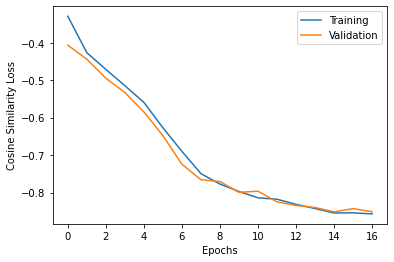

In [9]:
# Plot loss trajectory throughout training.
plt.figure()
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Cosine Similarity Loss')
plt.legend()

# Validation loss does not increase, so we are not overfitting

In [16]:
# This function draws an a 3-D vector from an isotropic distribution
def random_three_vector():

    """

    Generates a random 3D unit vector (direction) with a uniform spherical distribution
    Algo from http://stackoverflow.com/questions/5408276/python-uniform-spherical-distribution

    """

    phi = np.random.uniform()*2*np.pi

    costheta = 2.0*np.random.uniform()-1.0
    theta = np.arccos( costheta )

    x = np.sin(theta) * np.cos(phi)
    y = np.sin( theta) * np.sin(phi)
    z = np.cos( theta )

    return np.array([x,y,z])


In [50]:
ang3D =[]
ang2D_1 = []
ang2D_2 = []

# Loop through test set
for track, label in zip(X_test[1000:2000], Y_test[1000:2000]):
    
    # Convert track to dense, one-by-one
    dense_track = np.array([(track.to_dense()).detach().numpy()])
    
    # Predict direction
    pred = model.predict(dense_track)[0]
    # Convert label to array
    true = np.array(label)
    
    # Draw a random vector
    v_rand = random_three_vector()
    
    #create two vectors perpendicular to the true direction
    v1 = np.cross(v_rand,true)
    v2 = np.cross(v1,true)
    
    # Project prediction onto planes containing (v1,true) (v2,true) and normalize
    pred1 = np.dot(pred,true)*true + np.dot(pred,v1) * v1
    pred1 = pred1/np.linalg.norm(pred1)
    pred2 = np.dot(pred,true)*true + np.dot(pred,v2) * v2
    pred2 = pred2/np.linalg.norm(pred2)
    
    #determine angles
    ang3D += [np.arccos(np.dot(pred,true))*180/np.pi]
    
    # need condition to include negatives into sign of theta
    ang2D_1 += [ np.sign( np.dot(pred1,v1) ) * np.arccos(np.dot(pred1,true))*180/np.pi ]
    ang2D_2 += [ np.sign( np.dot(pred2,v2) ) * np.arccos(np.dot(pred2,true))*180/np.pi ]    

In [53]:
# Gaussian function to fit to
def func(x,sigma):
    return 1.0/(sigma*np.sqrt(2*np.pi))*np.e**(-(x**2)/(2*sigma**2))

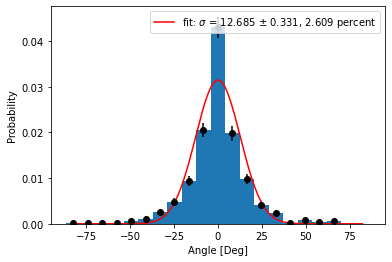

In [54]:
from scipy.optimize import curve_fit

Trim = 2.0

#Load data
angles = ang2D_1

# Trim the distribution
p1 = np.percentile(angles,Trim/2.0)
p2 = np.percentile(angles,100.0-Trim/2.0)
angles2 = []
for g in angles:
    if g > p1 and g < p2:
        angles2 += [g]
angles = angles2


# Bin the data s.t. the center of the central bin is 0,
# the outermost angle is in the center of the outermost bin
# and binning is symmetric about 0

#num is the number of bins on either side of the gaussian
num = 10

M1 = np.abs(min(angles))
M2 = np.abs(max(angles))
M = max(M1,M2)

# Make the bin ceneters
bin_centers = np.arange(-M,M+(M/num),M/num)
# Number of bin centers must be odd but sometimes numpy gives me and extra bin, I throw it out here
if len(bin_centers)%2 == 0:
    bin_centers = bin_centers[0:(len(bin_centers)-1)]

# Make the bin edges
bin_edges = []
for center in bin_centers:
    bin_edges += [center - M/(num*2.0)]
bin_edges += [M + M/(num*2.0)]

plt.figure()
# Bin the data
n, bins, patches = plt.hist(angles, density=True , bins=bin_edges)

#Ignore bins with no hits
bin_centers = bin_centers[n != 0]
diffs = np.diff(bins)[n != 0]
n = n[n != 0]

#Calculate number of hits per bin 
n_hits = n * (len(angles)*diffs)
#Calculate poission error bars on number of hits
n_hits_err = np.sqrt(n_hits)
#calculate error bars on n
n_err = n * (n_hits_err/n_hits)


plt.xlabel('Angle [Deg]')
plt.ylabel('Probability')
plt.errorbar(bin_centers, n, yerr=n_err,fmt='ko')

# Fit to binned density function 
#popt, pcov = curve_fit(func, bin_centers, n,absolute_sigma=True)
popt, pcov = curve_fit(func, bin_centers, n, sigma=n_err, absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))

# Plot the fit 
xs = np.arange(-M,M,2.0*M/1000)
plt.plot(xs,func(xs,*popt),'r-',label='fit: $\sigma$ = %5.3f $\pm$ %5.3f, %5.3f percent' % tuple([popt[0],perr[0],perr[0]/popt[0]*100.0]))
#plt.plot(xs,func(xs,popt[0]+perr[0]),'r--',label='fit Err high')
#plt.plot(xs,func(xs,popt[0]-perr[0]),'r--',label='fit Err low')
plt.legend()






In [41]:
ang2D_1
RMS_2D = np.sqrt(np.dot(ang2D_1,ang2D_1)/len(ang2D_1))
print(" 3D RMS = ",  RMS_2D)


 3D RMS =  25.58151571359083


In [40]:
t_ang3d = ang3D[0:int(0.98*len(ang3D))]

RMS_3D = np.sqrt(np.dot(t_ang3d,t_ang3d)/len(t_ang3d))
print(" 3D RMS = ",  RMS_3D)

 3D RMS =  31.76081351221033


In [23]:
# Save the model
name = "3DCNN_model"
model.save("/home/majd/CNN_models/"+name)

2022-08-19 22:42:32.872608: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/majd/CNN_models/3DCNN_model/assets


In [45]:
# Load the model
#model = keras.models.load_model("/home/majd/CNN_models/"+name)